In [1]:
from datasets import load_dataset, load_from_disk
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import reduce
import ast
import numpy as np
from typing import List, Dict, Tuple
import json
import hashlib
import pandas as pd

SAVE_DATASET_PATH = "../../data/qa_datasets/hotpotqa_distractor_validation/original"
SAVE_CONTEXTS_PATH = "../../data/qa_datasets/hotpotqa_distractor_validation/relevant_contexts.csv"
SAVE_TMP_CONTEXTS_PATH = "../../data/qa_datasets/hotpotqa_distractor_validation/tmp_hotpotqa_cntx.csv"
SAVE_QA_PATH = "../../data/qa_datasets/hotpotqa_distractor_validation/qa_pairs.csv"
SAVE_STATS_PATH = "../../data/qa_datasets/hotpotqa_distractor_validation/stats.json"
CNTX_MAX_LEN = 1024
CNTX_MIN_LEN = 64
MAX_QA_PAIRS = 2000

/home/dzigen/Desktop/PersonalAI/.pai_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Скачиваем датасет с Hugging Face

In [24]:
# https://huggingface.co/datasets/hotpotqa/hotpot_qa
valid_dataset = load_dataset("hotpotqa/hotpot_qa", "distractor", split="validation") # 7405
valid_dataset.save_to_disk(SAVE_DATASET_PATH)

Saving the dataset (1/1 shards): 100%|██████████| 7405/7405 [00:00<00:00, 16543.28 examples/s]


In [2]:
valid_dataset = load_from_disk(SAVE_DATASET_PATH)

#### Извлекаем все уникальные контексты (разбиваем их на чанки, т.к. они достаточно длинные)

In [5]:
base_supporting_facts = valid_dataset['supporting_facts']
base_contexts = valid_dataset['context']

In [6]:
unique_contexts = dict()
contexts_qa_idxes = defaultdict(list)

process = tqdm(range(valid_dataset.num_rows))
cntx_counter = 0
for i in process:
    supporting_facts = base_supporting_facts[i]
    contexts = base_contexts[i]

    process.set_postfix_str(f"unique contexts: {len(unique_contexts)} / {cntx_counter}")

    for title in supporting_facts['title']:
        title_index = contexts['title'].index(title)
        if len(title) < 1:
            raise ValueError
        rel_context = ' '.join(contexts['sentences'][title_index])
        
        cntx_hash = hashlib.sha1(rel_context.encode()).hexdigest()
        
        unique_contexts[cntx_hash] = (title, rel_context)
        contexts_qa_idxes[cntx_hash].append(i)
        cntx_counter += 1

100%|██████████| 7405/7405 [00:03<00:00, 2044.09it/s, unique contexts: 13781 / 18003]


Preparing contexts list

In [7]:
cntx_df_dict = {'context': [], 'title': [],'qa_idxes': []}
for cntx_hash in unique_contexts.keys():
    cntx_df_dict['title'].append(unique_contexts[cntx_hash][0])
    cntx_df_dict['context'].append(unique_contexts[cntx_hash][1])
    cntx_df_dict['qa_idxes'].append(contexts_qa_idxes[cntx_hash])

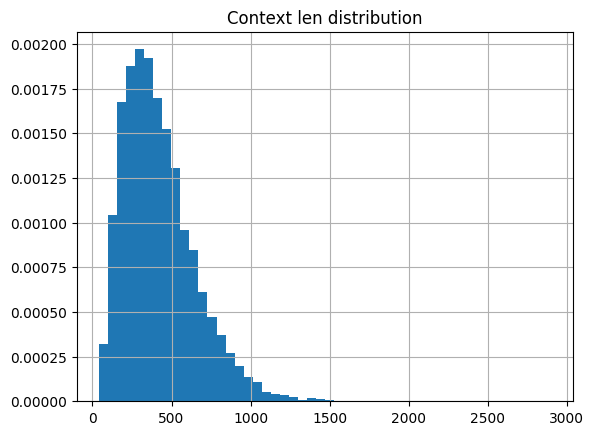

In [8]:
cntx_lens = list(map(lambda cntx: len(cntx), cntx_df_dict['context']))
plt.hist(cntx_lens, bins=50, density=True)
plt.title("Context len distribution")
plt.grid()
plt.show()

In [31]:
cntx_df = pd.DataFrame(cntx_df_dict)
cntx_df.to_csv(SAVE_TMP_CONTEXTS_PATH, index=False)

#### Фильтруем контексты по длине и максимальному количеству qa-пар

In [9]:
cntx_df = pd.read_csv(SAVE_TMP_CONTEXTS_PATH)
cntx_df['qa_idxes'] = cntx_df['qa_idxes'].map(lambda v: ast.literal_eval(v))

In [10]:
print(f"before: {cntx_df.shape}")

wolcnt_cntx_df = cntx_df[cntx_df['context'].str.len() <= CNTX_MAX_LEN].reset_index(drop=True)
print(f"after long contexts deletion: {wolcnt_cntx_df.shape}")

qa_idx_to_delete = set(reduce(lambda acc, v: acc + v, cntx_df[cntx_df['context'].str.len() > CNTX_MAX_LEN]['qa_idxes'].tolist(), []))
for i in tqdm(range(wolcnt_cntx_df.shape[0])):
    wolcnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolcnt_cntx_df['qa_idxes'][i]).difference(qa_idx_to_delete))
wolcnt_cntx_df = wolcnt_cntx_df[wolcnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after incomplete contexts deletion: {wolcnt_cntx_df.shape}")

wolscnt_cntx_df = wolcnt_cntx_df[wolcnt_cntx_df['context'].str.len() >= CNTX_MIN_LEN].reset_index(drop=True)
print(f"after small contexts deletion: {wolcnt_cntx_df.shape}")

qa_idx_to_delete = set(reduce(lambda acc, v: acc + v, wolcnt_cntx_df[wolcnt_cntx_df['context'].str.len() < CNTX_MIN_LEN]['qa_idxes'].tolist(), []))
for i in tqdm(range(wolscnt_cntx_df.shape[0])):
    wolscnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolscnt_cntx_df['qa_idxes'][i]).difference(qa_idx_to_delete))
wolscnt_cntx_df = wolscnt_cntx_df[wolscnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after incomplete contexts deletion: {wolscnt_cntx_df.shape}")

unique_qa_idxes = sorted(list(set(reduce(lambda acc, v: acc + v, wolscnt_cntx_df['qa_idxes'].tolist(), []))))[:MAX_QA_PAIRS]
for i in range(wolscnt_cntx_df.shape[0]):
    wolscnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolscnt_cntx_df['qa_idxes'][i]).intersection(unique_qa_idxes))
filtered_cntx_df = wolscnt_cntx_df[wolscnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after ommiting qa-pairs: {filtered_cntx_df.shape}")

before: (13783, 3)
after long contexts deletion: (13552, 3)


  0%|          | 0/13552 [00:00<?, ?it/s]

100%|██████████| 13552/13552 [00:01<00:00, 10052.98it/s]


after incomplete contexts deletion: (13325, 3)
after small contexts deletion: (13325, 3)


100%|██████████| 13307/13307 [00:01<00:00, 10258.62it/s]


after incomplete contexts deletion: (13291, 3)
after ommiting qa-pairs: (3933, 3)


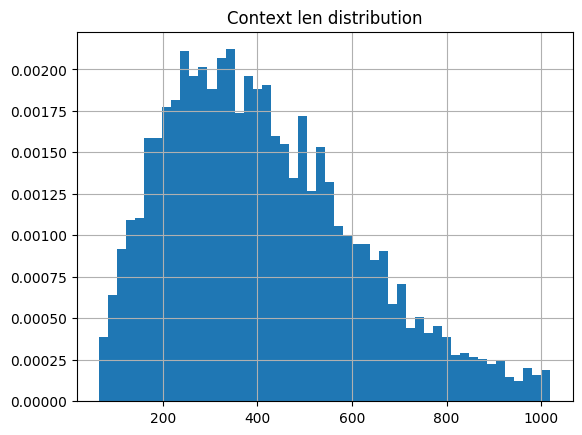

In [11]:
cntx_lens = list(map(lambda cntx: len(cntx), filtered_cntx_df['context']))
plt.hist(cntx_lens, bins=50, density=True)
plt.title("Context len distribution")
plt.grid()
plt.show()

In [12]:
filtered_cntx_df.to_csv(SAVE_CONTEXTS_PATH, index=False)

#### Формируем отдельный датасет с qa-парами (с учётом имеющегося набора отфильтрованных контекстов)

In [13]:
qa_df_dict = {'answer': [], 'question': [], 'qa_idx': []}

all_questions = valid_dataset['question']
all_answers = valid_dataset['answer']

for qa_idx in tqdm(unique_qa_idxes):
    qa_df_dict['answer'].append(all_answers[qa_idx])
    qa_df_dict['question'].append(all_questions[qa_idx])
    qa_df_dict['qa_idx'].append(qa_idx)

100%|██████████| 2000/2000 [00:00<00:00, 1514462.54it/s]


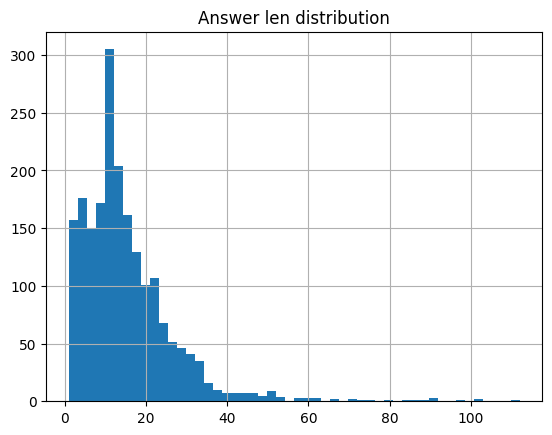

In [14]:
answer_lens = list(map(lambda cntx: len(cntx), qa_df_dict['answer']))
plt.hist(answer_lens, bins=50)
plt.title("Answer len distribution")
plt.grid()
plt.show()

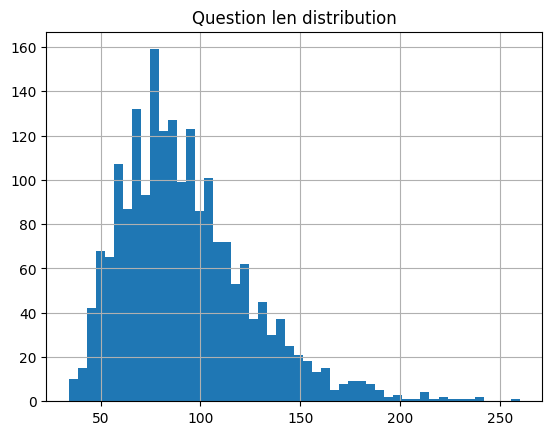

In [15]:
question_lens = list(map(lambda cntx: len(cntx), qa_df_dict['question']))
plt.hist(question_lens, bins=50)
plt.title("Question len distribution")
plt.grid()
plt.show()

In [16]:
qa_df = pd.DataFrame(qa_df_dict)
print(qa_df.shape)

(2000, 3)


In [17]:
print("Количество уникальных вопросов: ", len(qa_df['question'].unique()))

Количество уникальных вопросов:  2000


In [18]:
qa_df.to_csv(SAVE_QA_PATH, index=False)

#### Сохраняем статистику по полученным csv-файлам с контекстами и соответствующими qa-парами

In [19]:
def compute_stats(numbers: List[int]) -> Dict[str, float]:
    return {'median': round(np.median(numbers),5),
            'mean': round(np.mean(numbers),5),
            'std': round(np.std(numbers),5)}

In [20]:
filtered_ds_statistics = {
    'contexts_amount': filtered_cntx_df.shape[0],
    'contexts_len': compute_stats(list(map(lambda v: len(v), filtered_cntx_df['context'].tolist()))),
    'qa_pairs_amount': qa_df.shape[0],
    'answers_len':  compute_stats(list(map(lambda v: len(v), qa_df['answer'].tolist()))),
    'questions_len': compute_stats(list(map(lambda v: len(v), qa_df['question'].tolist())))
}

In [21]:
filtered_ds_statistics

{'contexts_amount': 3933,
 'contexts_len': {'median': 384.0, 'mean': 413.72616, 'std': 201.05291},
 'qa_pairs_amount': 2000,
 'answers_len': {'median': 13.0, 'mean': 15.295, 'std': 11.87228},
 'questions_len': {'median': 87.0, 'mean': 92.9825, 'std': 32.62646}}

In [22]:
with open(SAVE_STATS_PATH, 'w', encoding='utf-8') as fd:
    json.dump(filtered_ds_statistics, fd, indent=1, ensure_ascii=False)